In [6]:
from shapely.geometry import Point, Polygon
from shapely.plotting import patch_from_polygon
import matplotlib.pyplot as plt

In [20]:
room_coords = [(-10, -10), (-10, 10), (10, 10), (10, -10)]

def add_random_table(room_coords, table_size):
    ''' 
    :param room_coords: list of tuples (x,y) shape:(4,2) representing the coordinates of the room
    :param table_size: string representing the size of the table or two numbers representing width and length of the table
    :return: list of tuples (x,y) shape:(4,2) representing the coordinates of the table
    '''
    # handle parameter table_size
    if table_size == 'small': table_size = (1,2)
    elif table_size == 'medium': table_size = (1,3)
    elif table_size == 'large': table_size = (2,4)
    elif isinstance (table_size, tuple) and len(table_size) == 2: pass
    else : raise ValueError('table_size must be "small", "medium", "large" or a tuple of two numbers')

    # generate random coordinates for the table
    table_coords = generate_random_table_coords(room_coords, table_size)

def check_if_table_is_valid(room_coords, other_tables_coords, min_distance_between_tables):
    pass

def soft_check_if_there_is_enough_space_in_room(room_coords, other_tables_coords, table_size, min_distance_between_tables):
    ''' 
    soft check of whether the table will fit into the room
    Look if there is enough space to fit a table side-by-side with a single other table, iterating over all 4 sides
    This part might require extending if we want more than 3 tables (like 5), since it only really works for 1 table, 
    and loosely works for 2 tables (therefore a "soft_check" name)
    '''
    min_ = min(table_size) + min_distance_between_tables
    for other_table_coords in other_tables_coords:
        # calc distance between bottom side of the room and bottom side of the other table
        distance = other_table_coords[0][1] - room_coords[0][1]
        if distance >= min_: break
        # calc distance between right side of the room and right side of the other table
        distance = room_coords[2][0] - other_table_coords[2][0]
        if distance >= min_: break
        # calc distance between top side of the room and top side of the other table
        distance = room_coords[2][1] - other_table_coords[2][1]
        if distance >= min_: break
        # calc distance between left side of the room and left side of the other table
        distance = other_table_coords[0][0] - room_coords[0][0]
        if distance >= min_: break
        return False
    return True


def generate_random_table_coords(room_coords, table_size):
    pass


def plot(tables_coord,room_coord):
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    patch = patch_from_polygon(Polygon(room_coord), facecolor=[0,0,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
    ax.add_patch(patch)
    for table_coord in tables_coord:
        patch = patch_from_polygon(Polygon(table_coord), facecolor=[0,1,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
        ax.add_patch(patch)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    plt.show()

In [24]:
class orderderCoordinates:
    '''A lot of math simplifies if we know coordinates are always ordered'''
    def __init__(self, coords):
        self.coords = self.order_coord(coords)

    def order_coord(self, coords):
        '''
        order coordinates in following order:
        1. Left bottom corner
        2. Left top corner
        3. Right top corner
        4. Right bottom corner

        Running time complexity is decent, since we know there are always only 4 coordinates, didn't bother with optimization

        params: coords - list of tuples (x,y) shape:(4,2) representing the coordinates of the room or a table
        '''
        return_ = []
        # find left bottom corner
        left_bottom_corner = coords[0]
        for coord in coords:
            if coord[0] <= left_bottom_corner[0] and coord[1] <= left_bottom_corner[1]:
                left_bottom_corner = coord
        return_.append(left_bottom_corner)
        # find left top corner
        left_top_corner = coords[0]
        for coord in coords:
            if coord[0] <= left_top_corner[0] and coord[1] >= left_top_corner[1]:
                left_top_corner = coord

        if left_top_corner != left_bottom_corner:
            return_.append(left_top_corner)
        else: 
            raise Exception('left_top_corner == left_bottom_corner')
        
        # find right top corner
        right_top_corner = coords[0]
        for coord in coords:
            if coord[0] >= right_top_corner[0] and coord[1] >= right_top_corner[1]:
                right_top_corner = coord

        if right_top_corner != left_bottom_corner and right_top_corner != left_top_corner:
            return_.append(right_top_corner)
        else:
            raise Exception('right_top_corner == left_bottom_corner or right_top_corner == left_top_corner')
        
        # find right bottom corner
        right_bottom_corner = coords[0]
        for coord in coords:
            if coord[0] >= right_bottom_corner[0] and coord[1] <= right_bottom_corner[1]:
                right_bottom_corner = coord
        
        if right_bottom_corner != left_bottom_corner and right_bottom_corner != left_top_corner and right_bottom_corner != right_top_corner:
            return_.append(right_bottom_corner)
        else:
            raise Exception('right_bottom_corner == left_bottom_corner or right_bottom_corner == left_top_corner or right_bottom_corner == right_top_corner')
        
        return return_
        

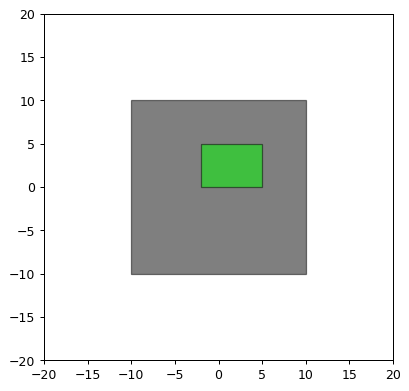

In [23]:
single_table_coords = [(-2,5), (-2,0), (5,0), (5,5)]
plot([single_table_coords],room_coords)